In [1]:
import sys
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
def print_progress_batch(step_in_one_batch, all_steps_in_one_batch, loss_value,batch_number=None, all_batchs=None):

    sys.stdout.flush()
    sys.stdout.write("[")
    sys.stdout.write("="*step_in_one_batch) # return to start of line, after '['
    sys.stdout.write(" "* (all_steps_in_one_batch-step_in_one_batch))
    if(batch_number is not None):
        sys.stdout.write("] batch = %d / %d epoch = %d / %d loss = %f \r" % (batch_number,all_batchs,step_in_one_batch,all_steps_in_one_batch,loss_value)) 
    else:
        sys.stdout.write("] epoch = %d / %d loss = %f \r" % (step_in_one_batch,all_steps_in_one_batch,loss_value)) 
    sys.stdout.flush()


In [3]:
class activation():
    
    def __init__(self, name="tanh"):
        name = name.strip().lower().replace(" ","").replace("_","")
        if(name not in ["tanh","sigmoid","relu","linear"]):
            raise ValueError(name +" is an unknown activation function")
        self.name = name
        self.method = None
        if(self.name == "tanh"):
            self.method = tanh_activation()
        elif(self.name == "sigmoid"):
            self.method = sigmoid_activation()
        elif(self.name == "relu"):
            self.method = relu_activation()
        elif(self.name == "linear"):
            self.method = linear_activation()
        pass;
    
    def activate(self,x):
        return self.method.activate(x)

    def prime(self, x):
        return self.method.prime(x)
    
class tanh_activation():
    def activate(self,x):
        return np.tanh(x)
    def prime(self, x):
        return 1-np.tanh(x)**2
    
class sigmoid_activation():
    def activate(self,x):
        return 1/(1+np.exp(-x))
    def prime(self, x):
        s = 1/(1+np.exp(-x))
        return s*(1-s) 

class relu_activation():
    def activate(self,x):
        return np.maximum(0,x)
    def prime(self, x):
        return np.where(x <= 0, 0, 1)

class linear_activation():
    def activate(self,x):
        return x
    def prime(self, x):
        return np.where(x <= 0, -1, 1)

In [4]:
class loss():
    
    def __init__(self, name="mse"):
        name = name.strip().lower().replace(" ","").replace("_","")
        if(name not in ["mse","rmse","mae","cross_entropy_loss"]):
            raise ValueError(name +" is an unknown loss function")
        self.name = name
        self.method = None
        if(self.name == "mse"):
            self.method = mse_loss()
        elif(self.name == "rmse"):
            self.method = rmse_loss()
        elif(self.name == "mae"):
            self.method = mae_loss()
        elif(self.name == "cross_entropy_loss"):
            self.method = cross_entropy_loss()
        pass;
    
    def compute_loss(self,y_true,y_pred):
        return self.method.loss(y_true,y_pred)

    def compute_loss_prime(self, y_true,y_pred):
        return self.method.loss_prime(y_true,y_pred)

class mse_loss():
    
    def loss(self,y_true,y_pred):
        return np.mean(np.power(y_true-y_pred, 2))
    def loss_prime(self, y_true,y_pred):
        return 2*(y_pred-y_true)/y_true.size

class mae_loss():
    
    def loss(self,y_true,y_pred):
        return np.mean(np.abs(y_true-y_pred))
    def loss_prime(self, y_true,y_pred):
        return np.mean(np.where((y_true-y_pred) < 0, 1.0, -1.0))

    
class rmse_loss():
    def loss(self,y_true,y_pred):
        return np.power(np.mean(np.power(y_true-y_pred, 2)),0.5)
    def loss_prime(self, y_true,y_pred):
        return (y_pred-y_true)/y_true.size
    
class cross_entropy_loss():
    # To implement later
    def loss(self,y_true,y_pred):
        pass;
    def loss_prime(self, y_true,y_pred):
        pass;

In [5]:
class dense_layer():
    
    def __init__(self, input_size, output_size,is_input_layer=False,is_trainable=True,rank_list_architecture=1):

        self.is_input_layer = is_input_layer
        self.input_size = input_size
        self.output_size = output_size
        self.is_trainable = is_trainable
        self.trainable_params = 0
        if(self.is_trainable):
            self.trainable_params = input_size*output_size
            
        self.weights = np.random.rand(input_size, output_size)
        self.bias = np.random.rand(1, output_size)
        
        if(self.is_trainable):
            self.name = str(rank_list_architecture)+"_ dense layer : ("+str(self.input_size)+","+str(self.output_size)+") "+str(self.trainable_params)+" params"
        else:
            self.name = str(rank_list_architecture)+"_ dense layer : ("+str(self.input_size)+","+str(self.output_size)+") Non trainale Layer"
    
    def set_repoductibikity(self,random_state):
        # Reproductibility
        np.random.seed(random_state)
        self.weights = np.random.rand(self.input_size, self.output_size)
        self.bias = np.random.rand(1, self.output_size)

    
    def update_name(self,rank_list_architecture):
        
        input_layer_type = "input layer" if(self.is_input_layer) else 'hidden layer'
        if(self.is_trainable):
            self.name = str(rank_list_architecture)+"_ dense "+input_layer_type+" : ("+str(self.input_size)+","+str(self.output_size)+") "+str(self.trainable_params)+" params"
        else:
            self.name = str(rank_list_architecture)+"_ dense "+input_layer_type+" : ("+str(self.input_size)+","+str(self.output_size)+") Non trainale Layer"
            
    def set_as_input_layer(self,is_input_layer, rank_list_architecture):
        self.is_input_layer = is_input_layer
        self.update_name(rank_list_architecture)
    
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        if(self.input.ndim == 1):
            self.input = self.input.reshape(-1,self.input.shape[0],1)
        input_error = np.dot(output_error, self.weights.T)
        if(self.is_input_layer):
            weights_error = np.dot(self.input, output_error).mean(0).reshape(self.input.shape[1],1)
        else:
            weights_error = np.dot(self.input.T, output_error).mean(0).reshape(self.input.shape[1],1)
            
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error


In [6]:
class activation_layer():
    
    def __init__(self, activation_function,rank_list_architecture=0):
        self.weights = None
        self.input = None
        self.output = None
        self.trainable_params = 0
        self.method = activation(activation_function)
        self.name = str(rank_list_architecture)+"_ activation layer : "+self.method.name
    
    def update_name(self,rank_list_architecture):
        self.name = str(rank_list_architecture)+"_ activation layer : "+self.method.name
        
    def set_as_input_layer(self,is_input_layer, rank_list_architecture):
        self.update_name(rank_list_architecture)
        pass;
    
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.method.activate(self.input)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.method.prime(self.input) * output_error


In [7]:
class gradient():
    
    def __init__(self, name, lr, nn_network, momentum=None, batch_size=None, nb_epochs=1, shuffle=False, verbose=False):
        
        name = name.strip().lower().replace("_"," ").replace("-"," ").replace("_"," ").replace(",","")
        
        if(name not in ["sgd","batch","mini batch"]):
            raise ValueError(name +" is an unknown gradient descente method")
        if(type(lr) is not float):
            raise ValueError("learning rate must be a float value")
        if(type(nn_network) not in [sequential_nn,sequential_nn]):
            raise ValueError("nn_network must be a neural network")
        if(type(verbose) is not bool):
            raise ValueError("verbose must be a boolean value")
        if(type(nb_epochs) is not int):
            raise ValueError("epochs must be an int value")
        if(batch_size is not None and type(batch_size) is not int):
            raise ValueError("batch_size must be an int value")
        if(type(shuffle) is not bool):
            raise ValueError("shuffle must be a boolean value")
            
        self.gradient_method = None
        
        if(name == "sgd"):
            self.gradient_method = sgd_gradient(name,lr, nn_network, momentum, nb_epochs, verbose)
        elif(name == "batch"):
            self.gradient_method = batch_gradient(name,lr, nn_network, nb_epochs, verbose)
        elif(name == "mini batch"):
            self.gradient_method = mini_batch_gradient(name,lr, nn_network, nb_epochs, batch_size, shuffle, verbose)
        self.name = self.gradient_method.name+self.gradient_method.show_spec()

    def solve(self,x_train, y_train):
        return self.gradient_method.solve(x_train, y_train)
    
class batch_gradient():
    
    def __init__(self, name, lr, nn_network, nb_epochs, verbose):
        
        self.name = name
        self.learning_rate = lr
        self.nn_network = nn_network
        self.nb_epochs = nb_epochs
        self.is_verbose = verbose
        self.loss_history = []
        
    def show_spec(self):
        specs = {"learning_rate":self.learning_rate,"epochs":self.nb_epochs}
        str_spec = ""
        for spec,val_spec in specs.items():
            if(val_spec is not None):
                str_spec +=  ("\n   - "+spec+" : "+str(val_spec))
        return str_spec
                
    def solve(self, x_train, y_train):
    
        for i in range(1,self.nb_epochs+1):
            outputs = x_train
            for layer in self.nn_network.layers:
                outputs = layer.forward_propagation(outputs)

            err_mean = self.nn_network.loss_method.compute_loss(y_train, outputs).mean()
            # backward propagation
            self.loss_history.append(err_mean)
            error = self.nn_network.loss_method.compute_loss_prime(y_train, outputs).mean()
            for layer in reversed(self.nn_network.layers):
                error = layer.backward_propagation(error, self.learning_rate)
            if(self.is_verbose):
                self.show_advance(i, err_mean)
                
        return self.loss_history
    
    def show_advance(self,step,mean_error):        
        #if(batch_number is not None):
        #print_progress_batch(i+1, epochs, err/samples, batch_number, all_batch)
        print_progress_batch(step,self.nb_epochs,mean_error)

        
class mini_batch_gradient():
    
    def __init__(self, name, lr, nn_network, nb_epochs, batch_size, shuffle, verbose):
        
        self.name = name
        self.learning_rate = lr
        self.nn_network = nn_network
        self.nb_epochs = nb_epochs
        self.is_verbose = verbose
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.actual_batch = 1
        self.nb_batchs = 1
        self.loss_history = []

    def show_spec(self):
        specs = {"learning_rate":self.learning_rate,"epochs":self.nb_epochs,"batch size":self.batch_size}
        str_spec = ""
        for spec,val_spec in specs.items():
            if(val_spec is not None):
                str_spec +=  ("\n   - "+spec+" : "+str(val_spec))
        return str_spec
    
    def solve(self, x_train, y_train):
        
        self.nb_batchs = (len(x_train)//self.batch_size) + (0 if(len(x_train)%self.batch_size == 0 ) else 1)
        for (mini_bach_x,mini_bach_y) in self.iterate_minibatches(x_train, y_train):
            print("")
            self.solve_batch(x_train=mini_bach_x, y_train=mini_bach_y)
            self.actual_batch += 1        
            sys.stdout.flush()
            print("")
        return self.loss_history
    
    def iterate_minibatches(self, x_train, y_train):
        
        assert x_train.shape[0] == y_train.shape[0]
        if self.shuffle:
            indices = np.arange(x_train.shape[0])
            np.random.shuffle(indices)
        
        for start_idx in range(0, x_train.shape[0] - self.batch_size + 1, self.batch_size):
            if self.shuffle:
                excerpt = indices[start_idx:start_idx + self.batch_size]
            else:
                excerpt = slice(start_idx, start_idx + self.batch_size)
        
            yield (x_train[excerpt], y_train[excerpt])

    def solve_batch(self, x_train, y_train):

        samples = len(x_train)
        for i in range(1,self.nb_epochs+1):
            err = 0
            outputs = []
            error = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.nn_network.layers:
                    output = layer.forward_propagation(output)

                err += self.nn_network.loss_method.compute_loss(y_train[j], output)
                outputs.append(output)
            # backward propagation
            self.loss_history.append(err/samples)
            error = self.nn_network.loss_method.compute_loss_prime(y_train, outputs).mean()
            for layer in reversed(self.nn_network.layers):
                error = layer.backward_propagation(error, self.learning_rate)
            
            if(self.is_verbose):
                self.show_advance(i, err/samples)
        
        return self.loss_history
    
    def show_advance(self,step,mean_error):        
        print_progress_batch(step, self.nb_epochs, mean_error, self.actual_batch, self.nb_batchs)

    
class sgd_gradient():
    
    def __init__(self, name, lr, nn_network, momentum, nb_epochs, verbose):
        
        self.name = name
        self.learning_rate = lr
        self.nn_network = nn_network
        self.momentum = momentum
        self.nb_epochs = nb_epochs
        self.is_verbose = verbose
        self.loss_history = []
        
    def show_spec(self):
        specs = {"learning_rate":self.learning_rate,"momentum":self.momentum,"epochs":self.nb_epochs}
        str_spec = ""
        for spec,val_spec in specs.items():
            if(val_spec is not None):
                str_spec +=  ("\n   - "+spec+" : "+str(val_spec))
        return str_spec
        
    def solve(self, x_train, y_train):
    
        samples = len(x_train)
        for i in range(1,self.nb_epochs+1):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.nn_network.layers:
                    output = layer.forward_propagation(output)

                err += self.nn_network.loss_method.compute_loss(y_train[j], output)
                self.loss_history.append(err/samples)
                # backward propagation
                error = self.nn_network.loss_method.compute_loss_prime(y_train[j], output)
                for layer in reversed(self.nn_network.layers):
                    error = layer.backward_propagation(error, self.learning_rate)
            if(self.is_verbose):
                self.show_advance(i, err/samples)
                
        return self.loss_history
    
    def show_advance(self,step,mean_error):        
        print_progress_batch(step,self.nb_epochs,mean_error)


In [8]:
class sequential_nn():
    
    def __init__(self):
        
        self.input_layer_set = False
        self.loss_method = None
        self.gradient = None
        self.layers = []
        self.is_model_build = False
        self.ranked_layers = 1
        
    def add_layer(self, layer):
        if(type(layer) is dense_layer or type(layer) is activation_layer):
            layer.set_as_input_layer(False,self.ranked_layers)
            if(not self.input_layer_set and type(layer) is dense_layer):
                self.input_layer_set = True
                layer.set_as_input_layer(True,self.ranked_layers)
                
            self.layers.append(layer)
            self.ranked_layers +=1
        else:
            raise ValueError(" sequential_nn add method accept only dense layer object")
           
    def build(self,loss_method,gradient_method):
        
        self.loss_method = loss(loss_method)
        #default values
        name, lr, nn_network, momentum, batch_size, nb_epochs, shuffle, verbose= "sgd",0.001,self,None,None,1,False,False  
        if("name" in gradient_method):
            name = gradient_method["name"]
        if("lr" in gradient_method):
            lr = gradient_method["lr"]
        if("momentum" in gradient_method):
            momentum = gradient_method["momentum"]
        if("batch_size" in gradient_method):
            batch_size = gradient_method["batch_size"]
        if("nb_epochs" in gradient_method):
            nb_epochs = gradient_method["nb_epochs"]
        if("verbose" in gradient_method):
            verbose = gradient_method["verbose"]    
        if("shuffle" in gradient_method):
            shuffle = gradient_method["shuffle"]    
        self.gradient = gradient(name, lr, nn_network, momentum, batch_size, nb_epochs, shuffle, verbose)
        
        if(len(self.layers)):
            self.is_model_build = True
        
    def get_summary(self):
        if(self.is_model_build):
            trainable_params = 0
            print("\n\n------------")
            print("Summary :   |")
            print("-"*65)
            print(" Architecture : ")
            for layer in self.layers: 
                print(" ",layer.name)
                trainable_params+= layer.trainable_params
            print("\n  Number of total model's trainable parameters  is "+ str(trainable_params))
            print("\n Model : ")
            print("  model is using "+ self.loss_method.name+" as a loss\n")
            print("  model is using : "+ self.gradient.name+"\n  as a gradient descente algorithm\n")
            print("-"*65)
            print("")
        
    # predict output for given input
    def predict(self, input_data):

        if(self.is_model_build):
            samples = len(input_data)
            result = []

            # run network over all samples
            for i in range(samples):
                # forward propagation
                output = input_data[i]
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                result.append(output.reshape(layer.output_size))

            return np.array(result)
        else:
            raise ValueError(" sequential_nn do not have any layer")
    
    
    def fit(self,x_train, y_train, batch_size=None, shuffle=False, random_state=None):
        
        
        if(self.is_model_build):
            if(random_state is not None):
                for layer in self.layers:
                    if(type(layer) is dense_layer):
                           layer.set_repoductibikity(random_state)

        
            loss_history = self.partial_fit(x_train=x_train, y_train=y_train)
            return loss_history
        else:
            raise ValueError(" sequential_nn do not have any layer")

    
    # train the network
    def partial_fit(self,x_train, y_train):

        loss_history = self.gradient.solve(x_train, y_train)
        return loss_history
                    
                    


# Test

In [9]:
def gen_data(nb_points,var):

    '''
        This function generate test sample :D 
    '''
    x = np.random.rand(nb_points, 2)*10 # [numPoints, 2] = Shape of data
    y =  x[:,0]*2+x[:,1]*5+ np.random.uniform(1, 2,nb_points) * var
    return x, y

def plot_model(x, ytrue, ypred):
    import matplotlib.pyplot as plt 
    plt.plot(np.arange(len(x)), ytrue, "x",label=" données initiales ")
    if(ypred is not None):
        plt.plot(np.arange(len(x)), ypred, "*",label="Droite Ajustée")
    plt.legend()
    plt.title("Visualisation des des données et de la ligne ajustée ")
    plt.show()

    
x, y = gen_data(1000, 5)
print(x.shape,y.shape)

(1000, 2) (1000,)




------------
Summary :   |
-----------------------------------------------------------------
 Architecture : 
  1_ dense input layer : (2,1) 2 params

  Number of total model's trainable parameters  is 2

 Model : 
  model is using rmse as a loss

  model is using : batch
   - learning_rate : 1.0
   - epochs : 100
  as a gradient descente algorithm

-----------------------------------------------------------------

100 0.7705540765863299===============================================================================] epoch = 100 / 100 loss = 22.555670 


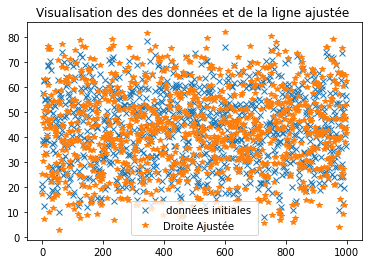

In [10]:
net = sequential_nn()
net.add_layer(dense_layer(2, 1))

gradient_method = {"name":"batch","lr":1.0, "momentum":None, "batch_size":10, "nb_epochs":100, "verbose":True}
net.build("rmse",gradient_method)
net.get_summary()
loss_history = net.fit(x, y, random_state=35)
# test
out = net.predict(x)
print(len(loss_history),r2_score(y, out))
plot_model(x,y,out)



------------
Summary :   |
-----------------------------------------------------------------
 Architecture : 
  1_ dense input layer : (2,1) 2 params

  Number of total model's trainable parameters  is 2

 Model : 
  model is using rmse as a loss

  model is using : mini batch
   - learning_rate : 0.1
   - epochs : 100
   - batch size : 100
  as a gradient descente algorithm

-----------------------------------------------------------------


[====================================================================================================] batch = 1 / 10 epoch = 100 / 100 loss = 11.608350 ================================================================                                   ] batch = 1 / 10 epoch = 65 / 100 loss = 11.274852 

[====================================================================================================] batch = 2 / 10 epoch = 100 / 100 loss = 10.984796 

[==========================================================================================

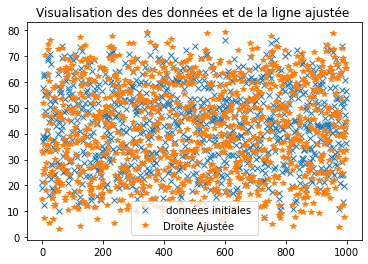

In [11]:
# network
net = sequential_nn()
net.add_layer(dense_layer(2, 1))
# train
gradient_method = {"name":"mini-batch","lr":0.1, "momentum":None, "batch_size":100, "nb_epochs":100, "verbose":True}
net.build("rmse",gradient_method)
net.get_summary()
loss_history = net.fit(x, y, random_state=35)
# test
out = net.predict(x)
print(len(loss_history),r2_score(y, out))
plot_model(x,y,out)



------------
Summary :   |
-----------------------------------------------------------------
 Architecture : 
  1_ dense input layer : (2,1) 2 params

  Number of total model's trainable parameters  is 2

 Model : 
  model is using rmse as a loss

  model is using : sgd
   - learning_rate : 0.0001
   - epochs : 100
  as a gradient descente algorithm

-----------------------------------------------------------------

100000 0.9893032075803997============================================================================] epoch = 100 / 100 loss = 1.316803 


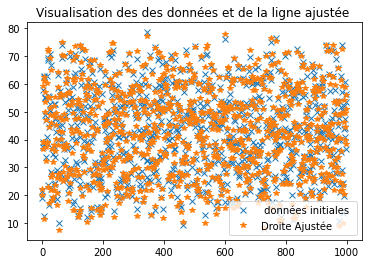

In [12]:
gradient_method = {"name":"sgd","lr":0.0001, "momentum":None, "batch_size":100, "nb_epochs":100, "verbose":True}
net = sequential_nn()
net.add_layer(dense_layer(2, 1))
net.build("rmse",gradient_method)
net.get_summary()
loss_history = net.fit(x, y, random_state=35)
# test
out = net.predict(x)
print(len(loss_history),r2_score(y, out))
plot_model(x,y,out)